In [56]:
%config Autocompleter.use_jedi=False

#### Feature Description:
    - Item_Identifier: Unique product ID
    - Item_Weight: Weight of product
    - Item_Fat_Content: Whether the product is low fat or not 
    - Item_Visibility: The % of total display area of all products in a store allocated to the particular product 
    - Item_Type: The category to which the product belongs 
    - Item_MRP: Maximum Retail Price (list price) of the product 
    - Outlet_Identifier: Unique store ID 
    - Outlet_Establishment_Year: The year in which store was established 
    - Outlet_Size: The size of the store in terms of ground area covered 
    - Outlet_Location_Type: The type of city in which the store is located 
    - Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket 
    - Item_Outlet_Sales: Sales of  the product in the particulat store. This is the outcome variable to be predicted. 


# 0. Importing libraries

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore,boxcox,probplot
import seaborn as sns
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

In [58]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [59]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# 1. Data Inspection
    - Summary of dataset
    - Checking for Null Values, Data Type of Features

In [60]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<h3><u>Observation:</u></h3>
    
#### Irrelevant columns are present which can be removed:
    1. Item_Identifier
    2. Outlet_Identifer (Can be useful in grouping and getting some other informations)
    3. Outlet_Establishment_Year (can be useful to draw some informataion or to do feature engineering)

#### Some columns are categorical which needs to be encoded further:
    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type

In [62]:
print('----------------% of missing Values in train set---------------------------- ')
np.round(train_df.isna().sum()/len(train_df) * 100,2)

----------------% of missing Values in train set---------------------------- 


Item_Identifier               0.00
Item_Weight                  17.17
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.28
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

In [63]:
print('----------------% of missing Values in test set---------------------------- ')
np.round(test_df.isna().sum()/len(test_df) * 100,2)

----------------% of missing Values in test set---------------------------- 


Item_Identifier               0.00
Item_Weight                  17.18
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.27
Outlet_Location_Type          0.00
Outlet_Type                   0.00
dtype: float64

<h3><u>Observation:</u></h3>

#### We can see 2 features have the missing values both in train and test dataset which needs to be handled:
    1. Item_Weight
    2. Outlet_Size
    
<b>Note:</b> There can be more missing features, but will have to look for it.

# 2. Data Cleaning
    - Handling Missing Data
    - Removing redundant and duplicate data
    - Handling untidy dataset etc

## 2.1 Handling Missing Data

#### Types of Missing Values:
    - NaN
    - 0 (depends on feature)
    - -1, -9,-99,-999 etc

#### Features with missing values:
    1. Item_Weight
    2. Outlet_Size
    
#### Techniques to handle missing values:
    1. Impute with (Mean, Median) -- good for continous feature
    2. Frequency based imputation (Mode)       -- good for categorical feature
    3. Deleting the NaN rows
    4. imputation based on predictions
    5. Regression Imputation  -- Good if feature is highly correlated
    6. KNN based imputation

In [64]:
wt_miss_val = train_df['Item_Weight'].isna().sum()
print('Total missing value for Item_Weight is {} out of {}'.format(wt_miss_val,len(train_df['Item_Weight'])))

Total missing value for Item_Weight is 1463 out of 8523


In [65]:
size_miss_val = train_df['Outlet_Size'].isna().sum()
print('Total missing value for Outlet_Size is {} out of {}'.format(size_miss_val,len(train_df['Outlet_Size'])))

Total missing value for Outlet_Size is 2410 out of 8523


<AxesSubplot:xlabel='Item_Weight'>

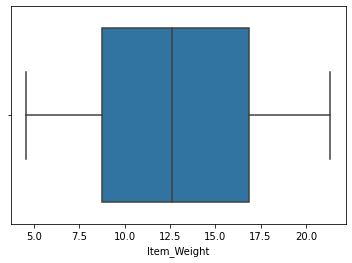

In [66]:
sns.boxplot(train_df['Item_Weight'])

It seems like outlier is not present in this feature so, we can replace the missing values with <b>mean</b> imputation.

In [67]:
# imputing Missing Value for Item_Weight with Mean
train_df['Item_Weight'].fillna(train_df['Item_Weight'].mean(),inplace=True)
test_df['Item_Weight'].fillna(test_df['Item_Weight'].mean(),inplace=True)

In [68]:
# imputing missing value for Outlet_Size based on frequency -- Medium here
print(train_df['Outlet_Size'].value_counts())

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


In [69]:
train_df['Outlet_Size'].fillna(train_df['Outlet_Size'].mode()[0],inplace=True)
test_df['Outlet_Size'].fillna(test_df['Outlet_Size'].mode()[0],inplace=True)

In [70]:
train_df['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

#### Observation:
    We can see that it has 0 values which is not possible in this case as, visibility of item in a store cannot be zero. So need to handle it.

In [71]:
per_missing_visib_train = len(train_df[train_df['Item_Visibility']==0])/len(train_df) * 100
per_missing_visib_test = len(test_df[test_df['Item_Visibility']==0])/len(test_df) * 100
print('Percent of missing values in Train->Item_Visibility are: {}%'.format(round(per_missing_visib_train,2)))
print('Percent of missing values in Test->Item_Visibility are: {}%'.format(round(per_missing_visib_test,2)))

Percent of missing values in Train->Item_Visibility are: 6.17%
Percent of missing values in Test->Item_Visibility are: 6.21%


<AxesSubplot:xlabel='Item_Visibility'>

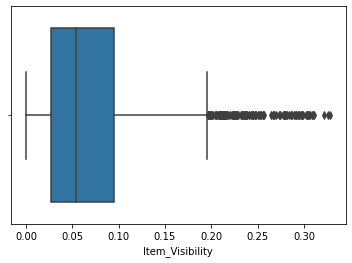

In [72]:
sns.boxplot(train_df['Item_Visibility'])

In [73]:
# Imputing Item_Visibility missinng values with Mean
train_df['Item_Visibility'].replace({0:train_df['Item_Visibility'].mean()},inplace=True)

## 2.2 Removing redundant and duplicate data

#### Feature having duplicate data values:
    - Item_Fat_Content

In [74]:
# Get all categorical features
[x for x in train_df.select_dtypes('object').columns]

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [75]:
train_df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [76]:
train_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

#### We can convert these multiple duplicate values to single as they denotes the same meaning
    - low fat, LF -> Low Fat & reg -> Regular

In [77]:
train_df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
test_df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
print(train_df['Item_Fat_Content'].value_counts())

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


# 3. EDA

    - Finding Correlations
    - Checking For multicolinearity
    - Univariate, Bivariate  Multivariate Analysis
    - Understanding about each and every features/columns/variables

## 3.1 Checking Correlation & Multicolinearity

<AxesSubplot:>

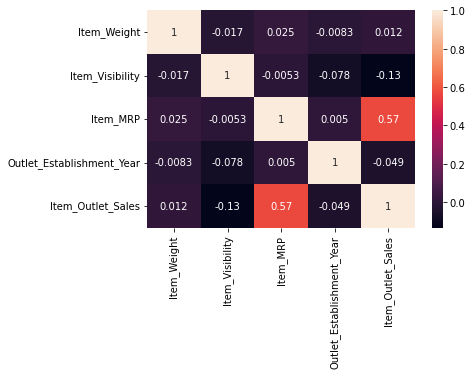

In [78]:
sns.heatmap(train_df.corr(),annot=True)

                        (Fig.- Correlation Heatmap for train data)

#### From this correlation heatmap it can be infered that there is no multicolinearity present.

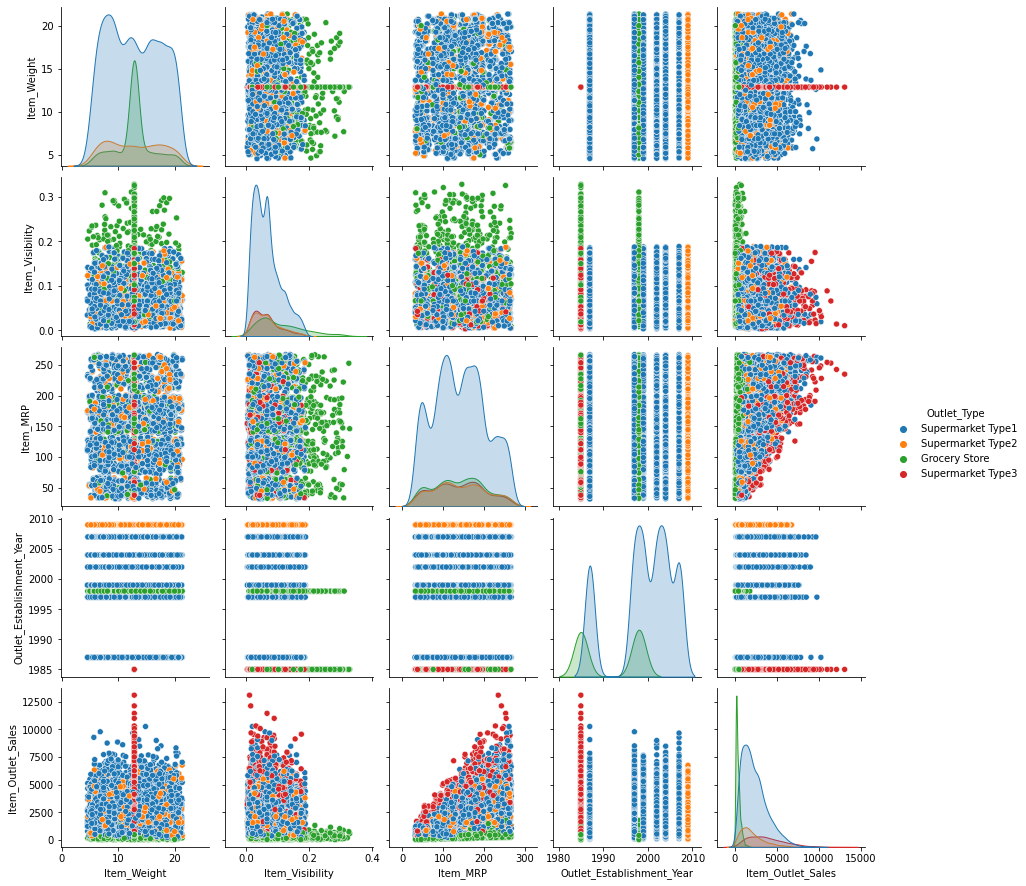

In [79]:
sns.pairplot(train_df,hue='Outlet_Type')

#### Some features are skewed which needs to be transformed (* if we use linear model else we can leave as it is):
    1. Item_Outlet_Sales (right skewed)
    2. Item_Visibility (right skewed)

#### From this diagram it can be inferred that:
    1. Overall Sales from all outlets  -> Supermarket Type1 > Supermarket Type3  > Grocery Store > Supermarket Type2
    2. Overall sales 
    3. Less sales from grocery store
    4. Outlet Establishments (earlier to later) => Supermarket Type3 -> Supermarket Type1 -> Grocery Store -> 
       Supermarket Type2
    

In [80]:
# sales_skewness = train_df['Item_Outlet_Sales'].skew()
# visibility_skewness = train_df['Item_Visibility'].skew()
# print('Skewness for Item_Outlet_Sales is {} and for Item_Visibility is {}'.format(sales_skewness,visibility_skewness))

#### From this it seems like these 2 features are highly skewed (>1), which can lead to unreliable results. So we need to transform it using either of these methods:
    1. Log transform (most preferred) -- We are going to use this over here
    2. Sqrt transform (generally less preferred)
    3. box-cox transform

In [81]:
# Applying log transform to both skewed feature
# train_df['Log_Item_Visibility'] = np.sqrt(train_df['Item_Visibility'])
# train_df['Log_Item_Outlet_Sales'] = np.log(train_df['Item_Outlet_Sales'])

# train_df.drop(columns=['Item_Visibility','Item_Outlet_Sales'],axis=1,inplace=True)

In [82]:
# sns.pairplot(train_df,hue='Outlet_Type')

#### After transforming the skewed data it can be inferred that:
    1. There is a positive correlation between MRP and sales.

In [83]:
# sns.heatmap(train_df.corr(),annot=True)

<center><b>Correlation after feature transformation</b></center>

## 3.2 Univariate Analysis

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

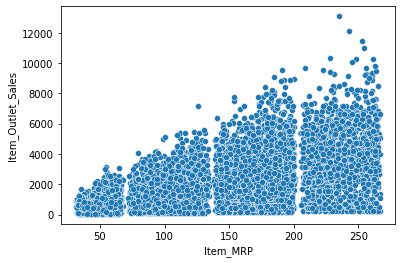

In [85]:
sns.scatterplot(x=train_df['Item_MRP'],y=train_df['Item_Outlet_Sales'])

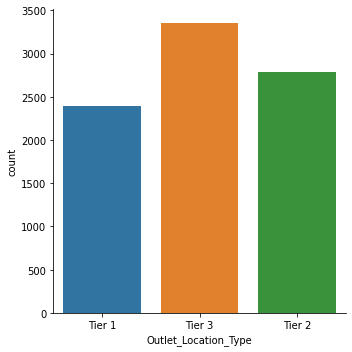

In [86]:
sns.catplot('Outlet_Location_Type',data=train_df,kind='count')

1. More no. of outlet in Tier 3 cities

<AxesSubplot:xlabel='Item_Type', ylabel='count'>

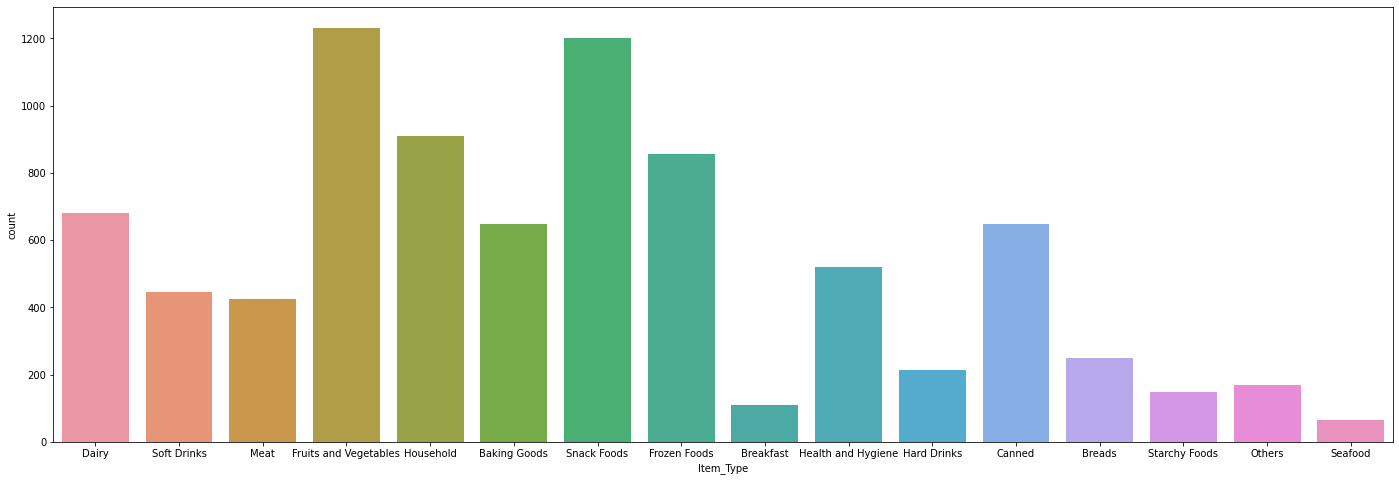

In [87]:
fig,ax = plt.subplots(figsize=(24,8))
sns.countplot(train_df['Item_Type'],ax=ax)

1. Fruits & vegetables are purchased more than others as it is of daily use.
2. Snack Foods also has high sales

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

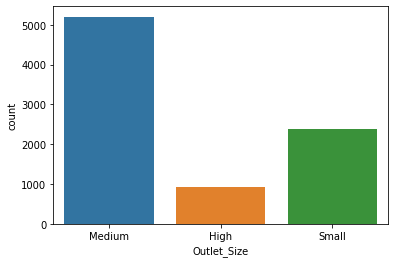

In [88]:
sns.countplot(train_df['Outlet_Size'])

1. Maximum outlet are of medium size

## 3.3 Bivariate Analysis

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

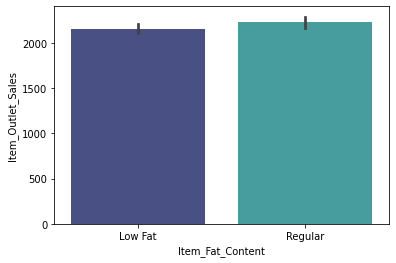

In [89]:
sns.barplot('Item_Fat_Content','Item_Outlet_Sales',data=train_df,palette='mako')

In [90]:
train_df.groupby(by='Outlet_Type')[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


#### Outlet Type Vs Avg Sales

In [92]:
train_df.groupby(by='Outlet_Size')[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Size,
High,2298.995256
Medium,2283.730470
Small,1912.149161


#### Outlet Size Vs Avg Sales

In [93]:
train_df.groupby(by='Outlet_Location_Type')[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 1,1876.909159
Tier 2,2323.990559
Tier 3,2279.627651


#### Outlet Location Type Vs Avg Sales

# 4. Feature Engineering

    - Handling Outliers
    - Handling irrelevant columns
    - Feature Encoding (handling categorical data)
    - Feature Generation
    - Selecting top/important features

## 4.1 Handling Outliers

<b>Note: </b> Outliers must be treated if we use linear model. 

#### Ways to treat outliers:
    1. Trimming/removing the outlier
    2. Quantile based flooring and capping
    3. Mean/Median imputation

## 4.2 Feature Encoding


#### Feature that needs to be encoded:

    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type 
    
#### Feature Encoding Techniques:
    1. Binary Encoding -> Item_Fat_Content
    2. Ordinal Encoding -> Outlet_Size, Outlet_Location_Type
    3. Nominal Encoding -> Outlet_Type, Item_Type
    4. Frequency Encoding
    
**  Item_Type is having large unique values

#### For Item_Type we will try grouping up some of the values to reduce unique values count:
    1. Drinks -> Soft Drinks, Hard Drinks
    2. Baking Goods -> Breads
    3. Meat -> Seafood


In [94]:
train_df['Item_Type'].replace({'Soft Drinks':'Drinks','Hard Drinks':'Drinks','Breads':'Baking Goods','Seafood':'Meat'},inplace=True)
test_df['Item_Type'].replace({'Soft Drinks':'Drinks','Hard Drinks':'Drinks','Breads':'Baking Goods','Seafood':'Meat'},inplace=True)

In [95]:
#Binary Encoding

train_df['Item_Fat_Content'].replace({'Low Fat':0,'Regular':1},inplace=True)
test_df['Item_Fat_Content'].replace({'Low Fat':0,'Regular':1},inplace=True)

In [96]:
#One_hot encoding nominal variables

def one_hot(df,columns,prefixes):
    df = df.copy()
    for column,prefix in zip(columns,prefixes):
        dummies = pd.get_dummies(df[column],prefix=prefix,drop_first=True)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(column,axis=1)
    return df

In [97]:
nominal_features = ['Outlet_Type','Item_Type']
prefixes = ['out_type','item_type']

train_df = one_hot(train_df,nominal_features,prefixes)
test_df = one_hot(test_df,nominal_features,prefixes)

In [98]:
#Ordinal Encoding

def ord_enc(df,col,ord_var):
    df = df.copy()
    df[col].replace(ord_var,inplace=True)
    return df

In [99]:
#Encoding Ordinal columns

outlet_size_ord = {'Small':0,'Medium':1,'High':2}
out_loc_ord = {'Tier 1':2,'Tier 2':1,'Tier 3':0}

train_df = ord_enc(train_df,'Outlet_Size',outlet_size_ord)
test_df = ord_enc(test_df,'Outlet_Size',outlet_size_ord)

train_df = ord_enc(train_df,'Outlet_Location_Type',out_loc_ord)
test_df = ord_enc(test_df,'Outlet_Location_Type',out_loc_ord)

## 4.3 Removing irrelevant columns

#### Irrelevant Columns in this dataset are: 
    1. Item_Identifier
    2. Outlet_Identifier

In [100]:
train_df.drop(columns=['Item_Identifier','Outlet_Identifier'],axis=1,inplace=True)
test_df.drop(columns=['Item_Identifier','Outlet_Identifier'],axis=1,inplace=True)

In [101]:
cat_feature_count = len(train_df.select_dtypes('object').count())
print('Total Categorical Features present : {}'.format(cat_feature_count))

Total Categorical Features present : 0


## 4.4 Feature Generation

In [102]:
# Deriving new column called Years_Since_Established from Establishment Year

train_df['Years_Since_Established'] = train_df['Outlet_Establishment_Year'].apply(lambda x: 2021 - x) 
test_df['Years_Since_Established'] = test_df['Outlet_Establishment_Year'].apply(lambda x: 2021 - x)

# 5. Splitting & Training Model

    1. Scaling
    2. Splitting
    3. Training

In [104]:
X = train_df.drop(columns=['Item_Outlet_Sales'],axis=1)
y = train_df['Item_Outlet_Sales']

In [117]:
# Scaling the feature
scale = StandardScaler()

In [105]:
trainX,testX,trainY,testY = train_test_split(X,y,random_state=42,test_size=0.25)

In [106]:
# trainX['Log_Item_Visibility'] = trainX['Log_Item_Visibility']**-1/2
# trainY = np.exp(trainY)
# testX['Log_Item_Visibility'] = testX['Log_Item_Visibility']**-1/2
# testY = np.exp(testY)

In [180]:
model_acc_scores = {}
def predictionResult(testY,pred,model_name,model):
    print('------------------Test Result---------------')
    print('--------------------{}------------------'.format(model_name))
    score = r2_score(testY,pred)
    mae = mean_absolute_error(testY,pred)
    mse = mean_squared_error(testY,pred)
    rmse = np.sqrt(mse)
    scores_dict = {'R2 Score':score,'Mean Absolute Error':mae,'Mean Squared Error':mse,'Root Mean Squared Error':rmse}
    model_acc_scores[model_name] = scores_dict
    print('R Squared Score is: {}'.format(score))
    print('Mean Absolute Error is: {}'.format(mae))
    print('Mean Squared Error is: {}'.format(mse))
    print('Root Mean Squared Error is: {}'.format(rmse))
    cv_score = cross_val_score(model,trainX,trainY,cv=5)
    print('------CV Score-------')
    print('CV Score for {} model is {}'.format(model_name,cv_score.mean()))
    print(sns.residplot(pred.reshape(-1),testY,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1}))
    
    plt.xlabel("Fitted values")
    plt.title('Residual plot')

    #Q-Q Plot
    residuals = testY - pred.reshape(-1)
    # residuals

    plt.figure(figsize=(7,7))
    print(probplot(residuals, dist="norm", plot=plt))
    plt.title("Normal Q-Q Plot")

------------------Test Result---------------
--------------------LinearRegression------------------
R Squared Score is: 0.5663984777410336
Mean Absolute Error is: 805.2963624589396
Mean Squared Error is: 1196296.75187088
Root Mean Squared Error is: 1093.7535151353252
------CV Score-------
CV Score for LinearRegression model is 0.556649169774582
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40966331, -3.15979525, -3.02127021, ...,  3.02127021,
        3.15979525,  3.40966331]), array([-3492.6808, -3376.9984, -3347.2664, ...,  4940.675 ,  5099.9256,
        5600.7528])), (1076.1946212717198, -29.401520788362525, 0.9828978328074639))


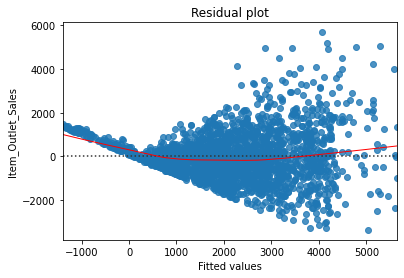

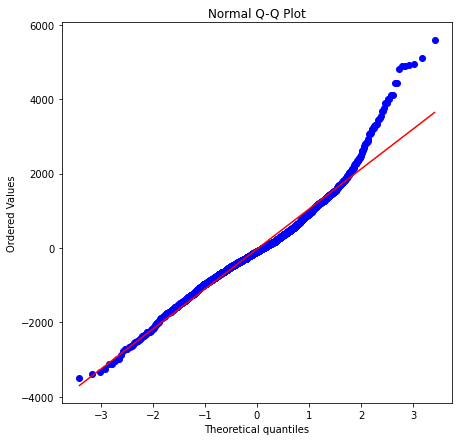

In [181]:
model_lin_reg = LinearRegression()

model_lin_reg.fit(trainX,trainY)

pred = model_lin_reg.predict(testX)
model_name = 'LinearRegression'

predictionResult(testY,pred,model_name,model_lin_reg)


Trining R2 Score: 0.6364730193489432
------------------Test Result---------------
--------------------RandomForestRegressor------------------
R Squared Score is: 0.6021569602888974
Mean Absolute Error is: 726.1157462440159
Mean Squared Error is: 1097639.910674893
Root Mean Squared Error is: 1047.6831155816596
------CV Score-------
CV Score for RandomForestRegressor model is 0.5955076648160813
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40966331, -3.15979525, -3.02127021, ...,  3.02127021,
        3.15979525,  3.40966331]), array([-4025.72617294, -3579.79089738, -3567.329858  , ...,
        5101.44109146,  5145.01514641,  5652.1550849 ])), (1022.1450505444368, -30.175019160026416, 0.9746368894623219))


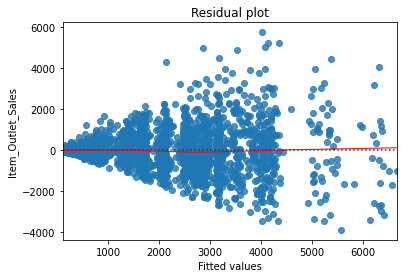

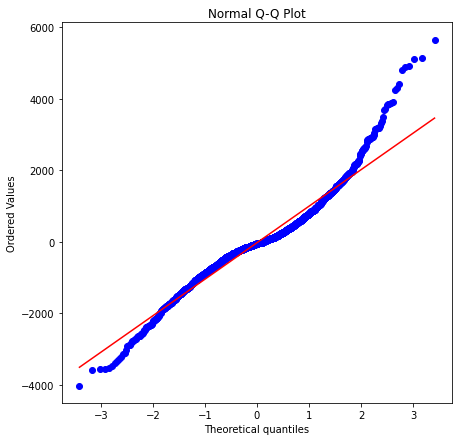

In [182]:
model_rf_reg = RandomForestRegressor(n_estimators=350,max_depth=6,random_state=2)
model_rf_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_rf_reg.score(trainX,trainY)))

pred = model_rf_reg.predict(testX)
model_name = 'RandomForestRegressor'

predictionResult(testY,pred,model_name,model_rf_reg)

Trining R2 Score: 0.6231102594775145
------------------Test Result---------------
--------------------CatBoostRegressor------------------
R Squared Score is: 0.6070175911213387
Mean Absolute Error is: 727.3301251957694
Mean Squared Error is: 1084229.5406037746
Root Mean Squared Error is: 1041.2634347770859
------CV Score-------
CV Score for CatBoostRegressor model is 0.5975014664866775
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40966331, -3.15979525, -3.02127021, ...,  3.02127021,
        3.15979525,  3.40966331]), array([-4178.74804698, -3593.24459071, -3570.8614069 , ...,
        4974.61371039,  5290.50139305,  5649.42041652])), (1015.6382595148793, -33.55827955720422, 0.9745051763508716))


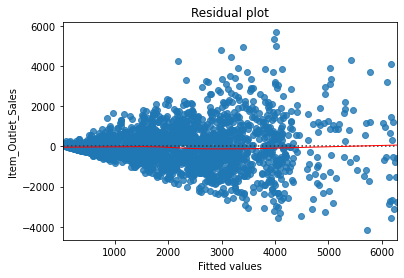

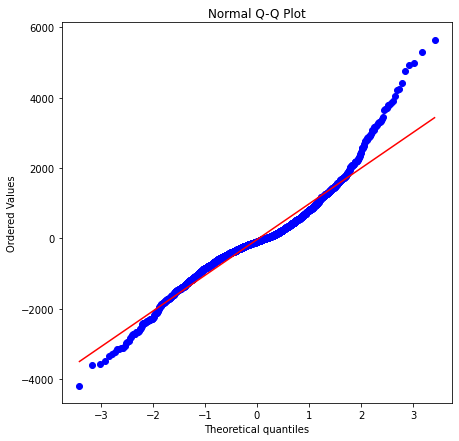

In [184]:
model_cat_reg = CatBoostRegressor(random_state=2,iterations=3000,learning_rate=0.002,depth=6,silent=True)
model_cat_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_cat_reg.score(trainX,trainY)))

pred = model_cat_reg.predict(testX)
model_name = 'CatBoostRegressor'

predictionResult(testY,pred,model_name,model_cat_reg)

Trining R2 Score: 0.61765378235275
------------------Test Result---------------
--------------------XGBRegressor------------------
R Squared Score is: 0.5956794024462373
Mean Absolute Error is: 763.1120377790519
Mean Squared Error is: 1115511.3456432463
Root Mean Squared Error is: 1056.1777055227242
------CV Score-------
CV Score for XGBRegressor model is 0.5849260347594377
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40966331, -3.15979525, -3.02127021, ...,  3.02127021,
        3.15979525,  3.40966331]), array([-3937.57337813, -3613.61627188, -3593.09176484, ...,
        4928.50616055,  5342.03058047,  5424.63707734])), (1034.4986779456353, -31.64395468271997, 0.9785161725483469))


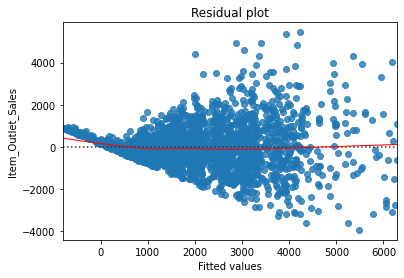

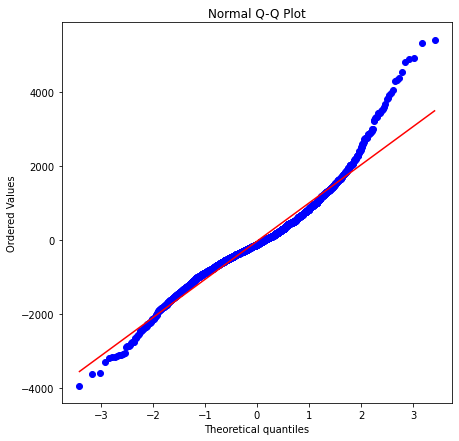

In [222]:
model_xgb_reg = XGBRegressor(colsample_bytree=0.5, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=7)
model_xgb_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_xgb_reg.score(trainX,trainY)))

pred = model_xgb_reg.predict(testX)
model_name = 'XGBRegressor'

predictionResult(testY,pred,model_name,model_xgb_reg)

#### This model (XGBRegressor) seems to be overfitting in this case without hyperparamter tuning

## Hyperparameter Tuning

#### Method used to perform Hyperparamter Tuning:
    1. GridSearchCV
    2. RandomizedSearchCV
    3. Coordinate Descent and etc

In [220]:
def randomSearch(model,params,trainX,testX,trainY,testY,scoring_name):
    grid = RandomizedSearchCV(estimator=model,param_distributions=params,scoring=scoring_name,verbose=3)
    grid.fit(trainX,trainY)
    print('------------Best Params----------')
    print(grid.best_params_)
    print('------------Best Score-----------')
    print(grid.best_score_)

In [221]:
xgb_params = {"learning_rate"    : [0.05, 0.10,0.002 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

xgb_model = XGBRegressor()
randomSearch(xgb_model,xgb_params,trainX,testX,trainY,testY,'r2')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.002, max_depth=6, min_child_weight=5;, score=-0.918 total time=   0.3s
[CV 2/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.002, max_depth=6, min_child_weight=5;, score=-0.915 total time=   0.3s
[CV 3/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.002, max_depth=6, min_child_weight=5;, score=-0.900 total time=   0.3s
[CV 4/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.002, max_depth=6, min_child_weight=5;, score=-0.977 total time=   0.3s
[CV 5/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.002, max_depth=6, min_child_weight=5;, score=-1.016 total time=   0.3s
[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.595 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=3;, score=0.569 total time=   0.1s
[CV 3/5] END c

In [158]:
model_performance = pd.DataFrame(model_acc_scores,)
model_performance.T

,R2 Score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
LinearRegression,0.566398,805.296362,1.196297e+06,1093.753515
RandomForestRegressor,0.602157,726.115746,1.097640e+06,1047.683116
CatBoostRegressor,0.607018,727.330125,1.084230e+06,1041.263435


In [ ]:
model_cat_reg = CatBoostRegressor(random_state=2,iterations=3000,learning_rate=0.002,depth=6)
# cv_score = cross_val_score(model_cat_reg,trainX,trainY,cv=5)
model_cat_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_cat_reg.score(trainX,trainY)))

pred = model_cat_reg.predict(testX)
model_name = 'CatBoostRegressor'

predictionResult(testY,pred,model_name)
# print('------CV Score-------')
print('CV Score for {} model is {}'.format(model_name,cv_score.mean()))
sns.residplot(pred.reshape(-1),testY,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

#Q-Q Plot
residuals = testY - pred.reshape(-1)
# residuals

plt.figure(figsize=(7,7))
probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")